In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [2]:
# Create evaluation directory if it doesn't exist
if not os.path.exists('evaluation'):
    os.makedirs('evaluation')

# Read the CSV file, add your link to the file
df = pd.read_csv('data/breast-cancer.csv')

# Store ID column separately if needed for reference
id_column = df['id']

# Display the first few rows
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [3]:
# Step 1: Basic Information
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst few rows:\n", df.head())

# Step 2: Missing Values Analysis
print("\nMissing values:\n", df.isnull().sum())
print("\nMissing values percentage:\n", (df.isnull().sum() / len(df)) * 100)

# Step 3: Basic Statistics
print("\nNumerical columns summary:\n", df.describe())
print("\nCategorical columns summary:\n", df.describe(include=['object']))

def clean_dataset(df):
    df_clean = df.copy()

    # Handle missing values
    # Example: Fill numeric columns with median
    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()

    # Handle outliers (example using IQR method for numeric columns)
    for col in numeric_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_clean

# Step 5: Data Visualization
def plot_distributions(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 6))
        if df[col].dtype in ['int64', 'float64']:
            sns.histplot(data=df, x=col)
        else:
            sns.countplot(data=df, x=col)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.savefig(f'evaluation/distribution_{col}.png', bbox_inches='tight', dpi=300)

# Step 6: Correlation Analysis (for numeric columns)
def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.savefig('evaluation/correlation_matrix.png', bbox_inches='tight', dpi=300)

Shape of dataset: (569, 32)

Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

Data types:
 id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float6


Original dataset shape: (569, 32)
Cleaned dataset shape: (569, 32)


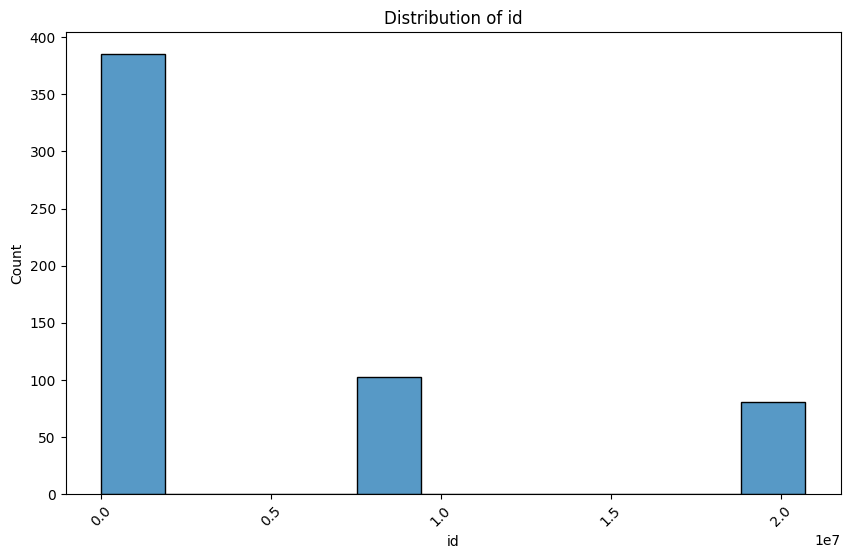

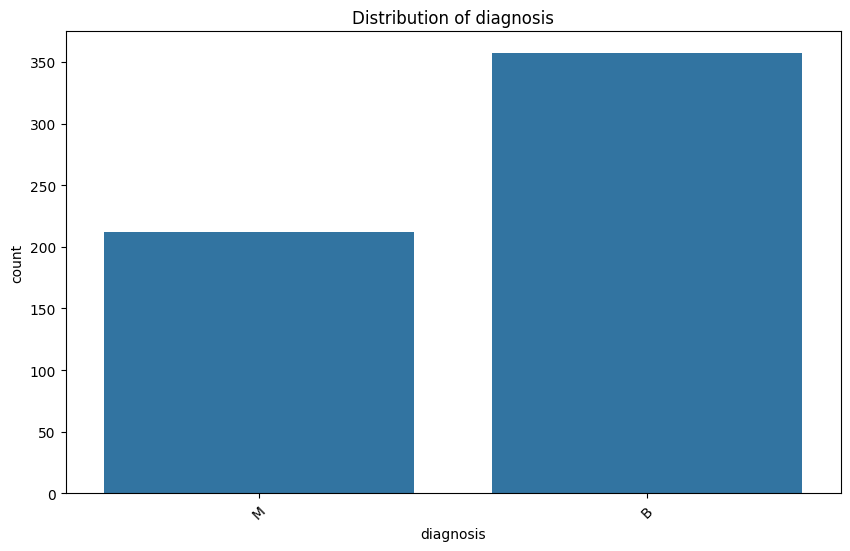

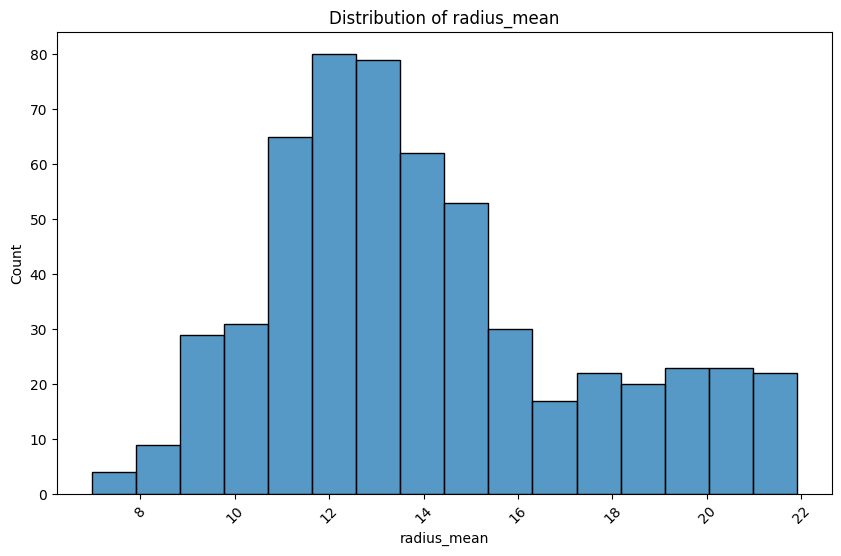

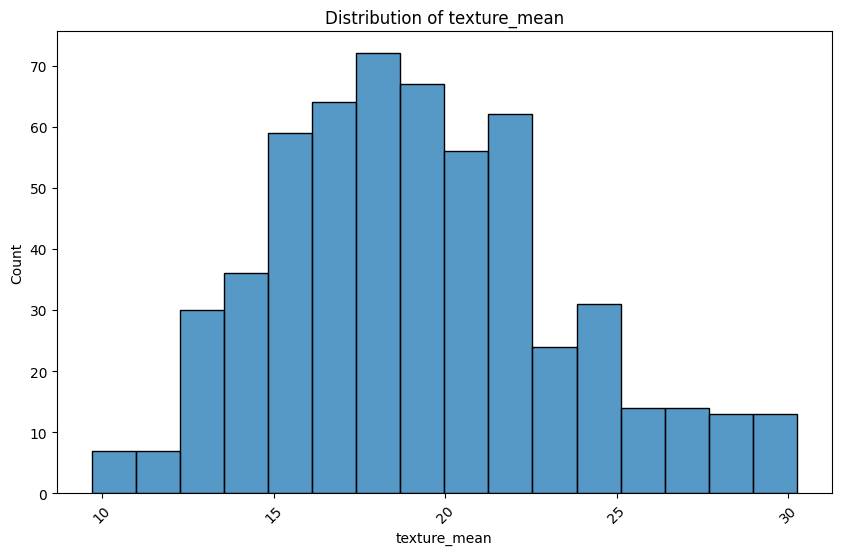

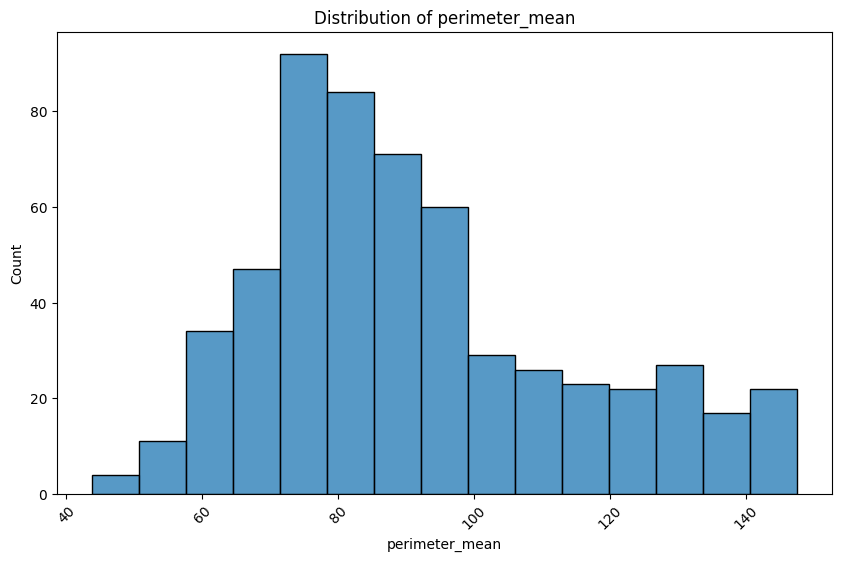

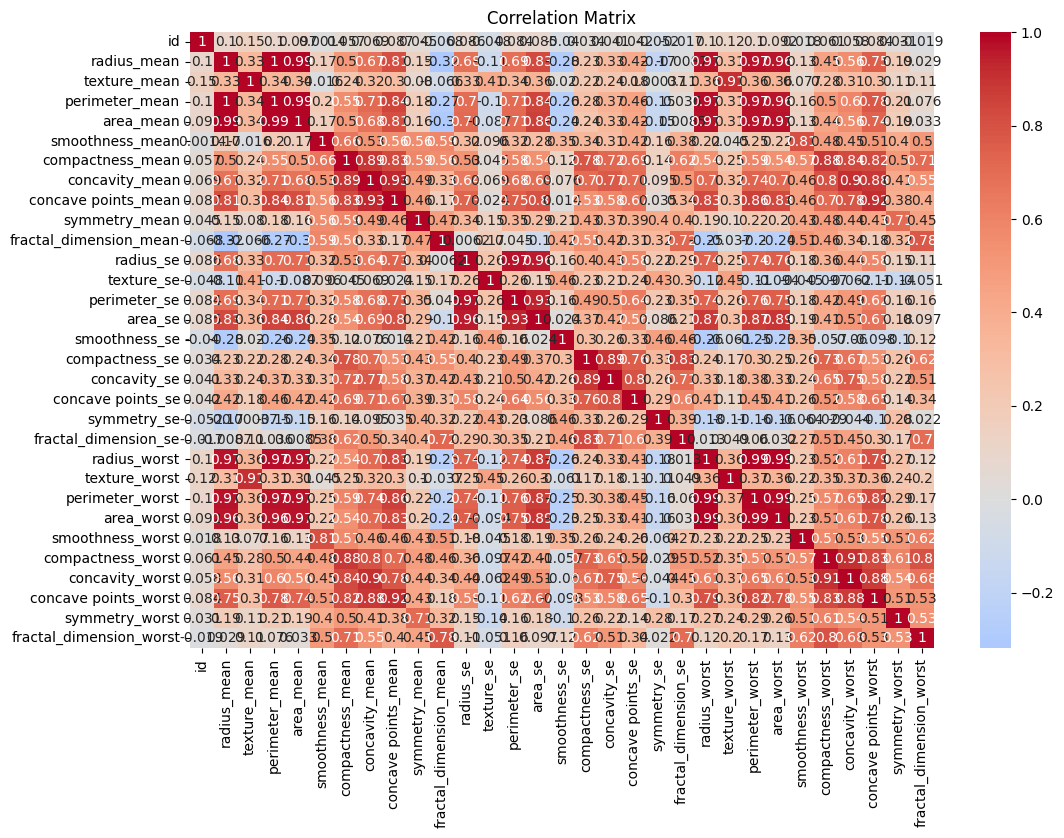

In [4]:
# Apply cleaning
df_clean = clean_dataset(df)

# Compare original and cleaned dataset
print("\nOriginal dataset shape:", df.shape)
print("Cleaned dataset shape:", df_clean.shape)

# Plot distributions for selected columns
plot_distributions(df_clean, df_clean.columns[:5])  # First 5 columns as example

# Plot correlation matrix
plot_correlation_matrix(df_clean)

# Add a new visualization for class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df_clean, x='diagnosis')
plt.title('Distribution of Diagnosis Classes')
plt.savefig('evaluation/class_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

# After dropping ID and Unnamed columns
# First, separate features (X) and target (y)
X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']  # Target

# Convert diagnosis to numeric (M=1, B=0)
y = (y == 'M').astype(int)

In [5]:
# =============== NEURAL NETWORK PIPELINE ================

# Convert categorical diagnosis to numeric (M=1, B=0)
df_clean['diagnosis'] = (df_clean['diagnosis'] == 'M').astype(int)

# Split features and target
X = df_clean.drop('diagnosis', axis=1)
y = df_clean['diagnosis']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Create PyTorch datasets
class BreastCancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = BreastCancerDataset(X_train, y_train)
test_dataset = BreastCancerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer3(x))
        return x

In [8]:
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
    # Save the trained model
    torch.save(model.state_dict(), 'evaluation/breast_cancer_model.pth')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('evaluation/training_loss.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            predicted = (outputs >= 0.5).float()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(outputs.cpu().numpy())
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('evaluation/confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # ROC curve
    plt.figure(figsize=(8, 6))
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig('evaluation/roc_curve.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Save metrics to file
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }
    
    with open('evaluation/metrics.txt', 'w') as f:
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
    
    return metrics

# Train and evaluate model
print("\n===== NEURAL NETWORK TRAINING =====")
trained_model = train_model(model, train_loader, criterion, optimizer, epochs=100)
print("\n===== NEURAL NETWORK EVALUATION =====")
metrics = evaluate_model(trained_model, test_loader)



===== NEURAL NETWORK TRAINING =====


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.